# Speech Emotion Recognition using Deep Learning

## Problem Statement

Emotion recognition from speech is a challenging problem in affective computing with applications in human-computer interaction, customer service analysis, mental health monitoring, and assistive technologies. The goal is to automatically classify the emotional state of a speaker based solely on acoustic features of their voice.

This is a multi-class classification problem where we aim to identify six distinct emotions: angry, disgust, fear, happy, neutral, and sad. The challenge lies in the fact that emotions are expressed differently across speakers, making this a speaker-independent recognition task where the model must generalize to voices it has never encountered during training.

## Approach

We approach this problem using a 2D Convolutional Neural Network (CNN) trained on mel-spectrogram representations of audio. Mel-spectrograms provide a time-frequency representation that preserves important prosodic features such as pitch contours, energy patterns, and temporal dynamics that are crucial for emotion recognition.

## Datasets

We utilize two publicly available emotional speech datasets from Kaggle:

1. **RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song)**
   - 2,880 audio files from 24 professional actors
   - High-quality studio recordings with controlled emotional expressions
   - Contributes diverse professional emotional portrayals

2. **CREMA-D (Crowd-sourced Emotional Multimodal Actors Dataset)**
   - 7,442 audio files from 91 actors
   - More naturalistic emotional expressions with demographic diversity
   - Provides real-world variability in emotional speech

By combining these datasets, we obtain approximately 10,000 labeled samples across six emotions, with 115 unique speakers. We use only emotions common to both datasets to ensure label consistency.

## Neural Network Architecture

We employ a 2D CNN architecture inspired by VGG networks, consisting of:
- Four convolutional blocks with batch normalization and max pooling
- Progressive filter sizes (32 -> 64 -> 128 -> 256) for hierarchical feature learning
- Dropout regularization (0.4-0.7) to prevent overfitting
- Two fully-connected layers for final classification

The model processes 128-band mel-spectrograms over 130 time frames, learning spatial patterns that correspond to emotional prosody.

## Training Strategy

To ensure robust generalization, we implement:
- **Speaker-level stratified splitting**: Train, validation, and test sets contain completely different speakers
- **Data augmentation**: Time masking, frequency masking, and spectral noise injection to simulate recording variations
- **Regularization**: Dropout layers and early stopping to prevent overfitting
- **Memory-efficient processing**: Batched feature extraction with garbage collection for Colab compatibility

## Expected Outcomes

With this approach, we expect to achieve 50-60% test accuracy on speaker-independent emotion recognition, which represents strong performance for this challenging task. The model will be deployed as an interactive web application allowing real-time emotion prediction from audio input.

## Cell 1: Installation and Imports

This cell installs required dependencies and imports necessary libraries for audio processing, machine learning, and visualization.

**Key Libraries:**
- `librosa`: Audio analysis and feature extraction
- `tensorflow/keras`: Deep learning framework
- `kagglehub`: Automated dataset downloading from Kaggle
- `scikit-learn`: Preprocessing and evaluation metrics

The cell also downloads the RAVDESS and CREMA-D datasets automatically from Kaggle, caching them locally for subsequent runs.

In [1]:
# Cell 1: Install and Import

!pip install kagglehub librosa soundfile tqdm -q

import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
import gc

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import kagglehub

ravdess_path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
crema_path = kagglehub.dataset_download("ejlok1/cremad")

print("RAVDESS path:", ravdess_path)
print("CREMA-D path:", crema_path)

Using Colab cache for faster access to the 'ravdess-emotional-speech-audio' dataset.
Using Colab cache for faster access to the 'cremad' dataset.
RAVDESS path: /kaggle/input/ravdess-emotional-speech-audio
CREMA-D path: /kaggle/input/cremad


## Cell 2: Dataset Configuration and Emotion Mapping

This cell defines the directory paths and establishes emotion label mappings for both datasets. Each dataset uses different encoding schemes:
- RAVDESS uses numeric codes (01-08)
- CREMA-D uses three-letter abbreviations (ANG, DIS, etc.)

We identify the intersection of emotions present in both datasets to ensure consistency. This results in six common emotions: angry, disgust, fear, happy, neutral, and sad. Using only common emotions prevents label ambiguity and ensures both datasets contribute equally to each emotion class.

In [2]:
# Cell 2: Setup

RAVDESS_DIR = ravdess_path
CREMA_DIR = crema_path

print("RAVDESS directory:", RAVDESS_DIR)
print("CREMA-D directory:", CREMA_DIR)

ravdess_emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fear",
    "07": "disgust",
    "08": "surprise",
}

crema_emotion_map = {
    "ANG": "angry",
    "DIS": "disgust",
    "FEA": "fear",
    "HAP": "happy",
    "NEU": "neutral",
    "SAD": "sad",
}

ravdess_emotions = set(ravdess_emotion_map.values())
crema_emotions = set(crema_emotion_map.values())
TARGET_EMOTIONS = sorted(list(ravdess_emotions & crema_emotions))

print("\nRAVDESS emotions:", sorted(ravdess_emotions))
print("CREMA-D emotions:", sorted(crema_emotions))
print("\nTarget emotions (common to both):", TARGET_EMOTIONS)

RAVDESS directory: /kaggle/input/ravdess-emotional-speech-audio
CREMA-D directory: /kaggle/input/cremad

RAVDESS emotions: ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
CREMA-D emotions: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']

Target emotions (common to both): ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']


## Cell 3: Data Loading Functions

This cell implements dataset-specific loading functions that parse filename conventions to extract emotion labels and speaker IDs.

**RAVDESS filename format:** `03-01-05-01-02-02-12.wav`
- Field 3 (index 2) contains the emotion code

**CREMA-D filename format:** `1001_DFA_ANG_XX.wav`
- Field 3 (index 2) contains the emotion abbreviation

Each function recursively walks through the dataset directory structure, extracts metadata from filenames, and creates a structured list of dictionaries containing file paths, emotion labels, speaker IDs, and dataset origin. This metadata is then combined into a single pandas DataFrame for unified processing.

In [3]:
# Cell 3: Load Data

def load_ravdess_files(root_dir):
    """Parse RAVDESS dataset filenames and extract metadata."""
    data = []
    for root, _, files in os.walk(root_dir):
        for f in files:
            if not f.lower().endswith(".wav"):
                continue

            parts = f.split("-")
            if len(parts) != 7:
                continue

            emotion_code = parts[2]
            emotion = ravdess_emotion_map.get(emotion_code)
            if emotion is None:
                continue

            speaker_id = parts[-1].split(".")[0]

            data.append({
                "dataset": "RAVDESS",
                "path": os.path.join(root, f),
                "emotion": emotion,
                "speaker": f"RAVDESS_{speaker_id}",
            })
    return data


def load_crema_files(root_dir):
    """Parse CREMA-D dataset filenames and extract metadata."""
    data = []
    for root, _, files in os.walk(root_dir):
        for f in files:
            if not f.lower().endswith(".wav"):
                continue

            parts = f.split("_")
            if len(parts) < 3:
                continue

            emotion_code = parts[2]
            emotion = crema_emotion_map.get(emotion_code)
            if emotion is None:
                continue

            speaker_id = parts[0]

            data.append({
                "dataset": "CREMA-D",
                "path": os.path.join(root, f),
                "emotion": emotion,
                "speaker": f"CREMA_{speaker_id}",
            })
    return data


ravdess_list = load_ravdess_files(RAVDESS_DIR)
crema_list = load_crema_files(CREMA_DIR)

print("RAVDESS files loaded:", len(ravdess_list))
print("CREMA-D files loaded:", len(crema_list))

df = pd.DataFrame(ravdess_list + crema_list)

print("Total audio files:", len(df))
print("\nDataset distribution:")
print(df["dataset"].value_counts())

RAVDESS files loaded: 2880
CREMA-D files loaded: 7442
Total audio files: 10322

Dataset distribution:
dataset
CREMA-D    7442
RAVDESS    2880
Name: count, dtype: int64


## Cell 4: Speaker-Independent Data Splitting

This cell implements a critical aspect of the experimental design: speaker-level stratified splitting. Unlike random splitting which can lead to speaker leakage (same speaker in both train and test), we ensure complete speaker independence across splits.

**Methodology:**
1. Extract unique speakers from each dataset separately
2. Randomly shuffle speakers within each dataset
3. Allocate 70% of speakers to training, 15% to validation, 15% to test
4. Perform this split independently for RAVDESS and CREMA-D
5. Concatenate the splits to ensure both datasets are represented in all partitions

**Rationale:**
This approach ensures the model is evaluated on entirely unseen speakers, simulating real-world deployment where the system must generalize to new voices. This is a much harder task than speaker-dependent recognition but provides more realistic performance estimates. The stratification ensures both datasets contribute proportionally to each split, preventing dataset bias in evaluation.

In [4]:
# Cell 4: Stratified Split

df = df[df["emotion"].isin(TARGET_EMOTIONS)].reset_index(drop=True)
print("Files after filtering to target emotions:", len(df))

print("\nEmotion distribution:")
print(df["emotion"].value_counts())

train_list, val_list, test_list = [], [], []
np.random.seed(42)

for dataset in df["dataset"].unique():
    dataset_df = df[df["dataset"] == dataset]
    speakers = dataset_df["speaker"].unique()
    np.random.shuffle(speakers)

    n = len(speakers)
    n_train = int(0.7 * n)
    n_val = int(0.15 * n)

    train_spk = speakers[:n_train]
    val_spk = speakers[n_train:n_train + n_val]
    test_spk = speakers[n_train + n_val:]

    train_list.append(dataset_df[dataset_df["speaker"].isin(train_spk)])
    val_list.append(dataset_df[dataset_df["speaker"].isin(val_spk)])
    test_list.append(dataset_df[dataset_df["speaker"].isin(test_spk)])

    print(f"\n{dataset} speaker split:")
    print(f"  Training: {len(train_spk)} speakers")
    print(f"  Validation: {len(val_spk)} speakers")
    print(f"  Test: {len(test_spk)} speakers")

train_df = pd.concat(train_list, ignore_index=True)
val_df = pd.concat(val_list, ignore_index=True)
test_df = pd.concat(test_list, ignore_index=True)

print("\nFinal split sizes:")
print(f"Training: {len(train_df)} samples")
print(f"Validation: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

Files after filtering to target emotions: 9554

Emotion distribution:
emotion
disgust    1655
fear       1655
happy      1655
sad        1655
angry      1655
neutral    1279
Name: count, dtype: int64

RAVDESS speaker split:
  Training: 16 speakers
  Validation: 3 speakers
  Test: 5 speakers

CREMA-D speaker split:
  Training: 63 speakers
  Validation: 13 speakers
  Test: 15 speakers

Final split sizes:
Training: 6562 samples
Validation: 1324 samples
Test: 1668 samples


## Cell 5: Mel-Spectrogram Feature Extraction

This cell defines functions for converting raw audio waveforms into mel-spectrogram representations, which serve as input to the neural network.

**Mel-Spectrogram Properties:**
- 128 mel-frequency bands (perceptually-scaled frequency bins)
- 130 time frames (corresponding to 3 seconds of audio at 512 hop length)
- Logarithmic amplitude scaling (dB) to match human perception

**Feature Extraction Pipeline:**
1. Convert audio to mono if stereo
2. Trim silence from beginning and end (top_db=20)
3. Compute mel-spectrogram using Short-Time Fourier Transform
4. Convert to log scale (decibels)
5. Pad or truncate to fixed 130-frame length

**Data Augmentation Functions:**
We implement SpecAugment-style augmentations to improve model robustness:
- Time masking: Randomly masks contiguous time frames to simulate temporal occlusions
- Frequency masking: Masks frequency bands to encourage use of diverse features
- Spectral noise: Adds Gaussian noise to simulate recording imperfections

These augmentations help the model generalize across different recording conditions and speaking styles.

In [5]:
# Cell 5: Feature Extraction Functions

SR = 22050
DURATION = 3.0
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
MAX_TIME_FRAMES = 130

def extract_mel_spectrogram(y, sr=SR, n_mels=N_MELS, n_fft=N_FFT,
                           hop_length=HOP_LENGTH, max_frames=MAX_TIME_FRAMES):
    """Extract log mel-spectrogram from audio signal."""
    if y.ndim > 1:
        y = librosa.to_mono(y)

    y, _ = librosa.effects.trim(y, top_db=20)

    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length
    )

    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    if log_mel_spec.shape[1] < max_frames:
        pad_width = max_frames - log_mel_spec.shape[1]
        log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, pad_width)), mode='constant')
    else:
        log_mel_spec = log_mel_spec[:, :max_frames]

    return log_mel_spec


def time_mask(mel_spec, T=15):
    """Apply time masking augmentation."""
    spec = mel_spec.copy()
    t = np.random.randint(0, T)
    t0 = np.random.randint(0, mel_spec.shape[1] - t)
    spec[:, t0:t0+t] = spec.mean()
    return spec


def freq_mask(mel_spec, F=20):
    """Apply frequency masking augmentation."""
    spec = mel_spec.copy()
    f = np.random.randint(0, F)
    f0 = np.random.randint(0, mel_spec.shape[0] - f)
    spec[f0:f0+f, :] = spec.mean()
    return spec


def add_noise_spec(mel_spec, noise_factor=0.02):
    """Add Gaussian noise to mel-spectrogram."""
    noise = np.random.randn(*mel_spec.shape) * noise_factor * mel_spec.std()
    return mel_spec + noise

print("Feature extraction functions defined")
print(f"Audio parameters: SR={SR}Hz, Duration={DURATION}s, Mel bands={N_MELS}")

Feature extraction functions defined
Audio parameters: SR=22050Hz, Duration=3.0s, Mel bands=128


## Cell 6: Memory-Efficient Dataset Construction

This cell builds the mel-spectrogram dataset using a batched processing approach to avoid memory overflow in Google Colab's limited RAM environment (12-15GB).

**Memory Optimization Strategy:**
1. Process audio files in batches of 500 (instead of loading all at once)
2. Use float32 precision instead of float64 (50% memory reduction)
3. Explicitly delete intermediate variables and force garbage collection
4. Concatenate batches progressively to build final dataset

**Data Augmentation:**
For training data only, we apply 2 augmented versions per original sample, randomly combining:
- Time masking (50% probability)
- Frequency masking (50% probability)
- Spectral noise (50% probability)

This results in approximately 3x the training data (original + 2 augmented versions), improving model robustness without requiring additional labeled samples.

**Processing Time:**
The complete feature extraction takes approximately 10-15 minutes for all three splits. Validation and test sets are not augmented to provide unbiased performance evaluation.

In [6]:
# Cell 6: Build Dataset

def build_mel_dataset_batched(df_subset, augment=False, n_augments=2, batch_size=500):
    """Build mel-spectrogram dataset using batched processing to manage memory."""
    X_batches, y_batches = [], []
    num_batches = int(np.ceil(len(df_subset) / batch_size))

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(df_subset))
        batch_df = df_subset.iloc[start_idx:end_idx]

        X_list, y_list = [], []

        for i, row in tqdm(batch_df.iterrows(), total=len(batch_df),
                          desc=f"Batch {batch_idx+1}/{num_batches}"):
            path, label = row["path"], row["emotion"]

            try:
                y_audio, sr = librosa.load(path, sr=SR, duration=DURATION)
            except Exception as e:
                print(f"Error loading {path}: {e}")
                continue

            target_len = int(SR * DURATION)
            if len(y_audio) < target_len:
                y_audio = np.pad(y_audio, (0, target_len - len(y_audio)), mode='constant')

            mel_spec = extract_mel_spectrogram(y_audio, sr)
            X_list.append(mel_spec)
            y_list.append(label)

            if augment:
                for _ in range(n_augments):
                    mel_aug = mel_spec.copy()
                    if np.random.rand() < 0.5:
                        mel_aug = time_mask(mel_aug, T=15)
                    if np.random.rand() < 0.5:
                        mel_aug = freq_mask(mel_aug, F=20)
                    if np.random.rand() < 0.5:
                        mel_aug = add_noise_spec(mel_aug, noise_factor=0.02)
                    X_list.append(mel_aug)
                    y_list.append(label)

            del y_audio

        X_batch = np.array(X_list, dtype=np.float32)
        y_batch = np.array(y_list)
        X_batches.append(X_batch)
        y_batches.append(y_batch)

        del X_list, y_list
        gc.collect()
        print(f"Batch {batch_idx+1}/{num_batches} complete: {X_batch.shape}")

    X = np.concatenate(X_batches, axis=0)
    y = np.concatenate(y_batches, axis=0)
    del X_batches, y_batches
    gc.collect()

    return X, y


print("Building training set with augmentation...")
X_train, y_train = build_mel_dataset_batched(train_df, augment=True, n_augments=2, batch_size=500)
gc.collect()

print("\nBuilding validation set...")
X_val, y_val = build_mel_dataset_batched(val_df, augment=False, batch_size=500)
gc.collect()

print("\nBuilding test set...")
X_test, y_test = build_mel_dataset_batched(test_df, augment=False, batch_size=500)
gc.collect()

print("\nDataset shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Building training set with augmentation...


Batch 1/14: 100%|██████████| 500/500 [00:28<00:00, 17.82it/s]


Batch 1/14 complete: (1500, 128, 130)


Batch 2/14: 100%|██████████| 500/500 [00:12<00:00, 38.47it/s]


Batch 2/14 complete: (1500, 128, 130)


Batch 3/14: 100%|██████████| 500/500 [00:13<00:00, 36.20it/s]


Batch 3/14 complete: (1500, 128, 130)


Batch 4/14: 100%|██████████| 500/500 [00:11<00:00, 42.95it/s]


Batch 4/14 complete: (1500, 128, 130)


Batch 5/14: 100%|██████████| 500/500 [00:11<00:00, 42.27it/s]


Batch 5/14 complete: (1500, 128, 130)


Batch 6/14: 100%|██████████| 500/500 [00:11<00:00, 42.85it/s]


Batch 6/14 complete: (1500, 128, 130)


Batch 7/14: 100%|██████████| 500/500 [00:11<00:00, 43.40it/s]


Batch 7/14 complete: (1500, 128, 130)


Batch 8/14: 100%|██████████| 500/500 [00:12<00:00, 40.44it/s]


Batch 8/14 complete: (1500, 128, 130)


Batch 9/14: 100%|██████████| 500/500 [00:11<00:00, 42.09it/s]


Batch 9/14 complete: (1500, 128, 130)


Batch 10/14: 100%|██████████| 500/500 [00:12<00:00, 41.25it/s]


Batch 10/14 complete: (1500, 128, 130)


Batch 11/14: 100%|██████████| 500/500 [00:12<00:00, 41.42it/s]


Batch 11/14 complete: (1500, 128, 130)


Batch 12/14: 100%|██████████| 500/500 [00:11<00:00, 42.27it/s]


Batch 12/14 complete: (1500, 128, 130)


Batch 13/14: 100%|██████████| 500/500 [00:11<00:00, 42.35it/s]


Batch 13/14 complete: (1500, 128, 130)


Batch 14/14: 100%|██████████| 62/62 [00:01<00:00, 45.58it/s]


Batch 14/14 complete: (186, 128, 130)

Building validation set...


Batch 1/3: 100%|██████████| 500/500 [00:11<00:00, 42.11it/s]


Batch 1/3 complete: (500, 128, 130)


Batch 2/3: 100%|██████████| 500/500 [00:11<00:00, 43.51it/s]


Batch 2/3 complete: (500, 128, 130)


Batch 3/3: 100%|██████████| 324/324 [00:07<00:00, 45.04it/s]


Batch 3/3 complete: (324, 128, 130)

Building test set...


Batch 1/4: 100%|██████████| 500/500 [00:12<00:00, 40.01it/s]


Batch 1/4 complete: (500, 128, 130)


Batch 2/4: 100%|██████████| 500/500 [00:10<00:00, 45.77it/s]


Batch 2/4 complete: (500, 128, 130)


Batch 3/4: 100%|██████████| 500/500 [00:10<00:00, 47.93it/s]


Batch 3/4 complete: (500, 128, 130)


Batch 4/4: 100%|██████████| 168/168 [00:04<00:00, 40.13it/s]


Batch 4/4 complete: (168, 128, 130)

Dataset shapes:
X_train: (19686, 128, 130), y_train: (19686,)
X_val: (1324, 128, 130), y_val: (1324,)
X_test: (1668, 128, 130), y_test: (1668,)


## Cell 7: Data Preprocessing and Encoding

This cell applies final preprocessing steps before model training:

**Normalization:**
Each mel-spectrogram is normalized to zero mean and unit variance. This standardization is performed independently per sample (not globally) to preserve relative intensity patterns within each utterance while ensuring consistent scale across samples.

**Label Encoding:**
Emotion labels (strings) are converted to integer indices using scikit-learn's LabelEncoder, then one-hot encoded for multi-class classification. The label encoder is saved for later use in prediction and deployment.

**Tensor Reshaping:**
Mel-spectrograms are reshaped from (samples, 128, 130) to (samples, 128, 130, 1) to match the expected input format for 2D convolutions, where the final dimension represents the channel count (analogous to RGB channels in images, but we have a single channel here).

**Memory Management:**
Original arrays are deleted immediately after creating normalized/reshaped versions to minimize memory footprint during this preprocessing stage.

In [7]:
# Cell 7: Preprocessing

def normalize_spec(X):
    """Normalize each mel-spectrogram independently."""
    X_norm = np.zeros_like(X, dtype=np.float32)
    for i in range(X.shape[0]):
        mean, std = X[i].mean(), X[i].std()
        X_norm[i] = (X[i] - mean) / (std + 1e-8)
    return X_norm

print("Normalizing mel-spectrograms...")
X_train_norm = normalize_spec(X_train)
del X_train
gc.collect()

X_val_norm = normalize_spec(X_val)
del X_val
gc.collect()

X_test_norm = normalize_spec(X_test)
del X_test
gc.collect()

label_encoder = LabelEncoder()
y_train_int = label_encoder.fit_transform(y_train)
y_val_int = label_encoder.transform(y_val)
y_test_int = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)
print(f"\nEmotion classes: {label_encoder.classes_}")
print(f"Number of classes: {num_classes}")

y_train_cat = to_categorical(y_train_int, num_classes)
y_val_cat = to_categorical(y_val_int, num_classes)
y_test_cat = to_categorical(y_test_int, num_classes)

X_train_cnn = np.expand_dims(X_train_norm, axis=-1)
del X_train_norm
gc.collect()

X_val_cnn = np.expand_dims(X_val_norm, axis=-1)
del X_val_norm
gc.collect()

X_test_cnn = np.expand_dims(X_test_norm, axis=-1)
del X_test_norm
gc.collect()

print(f"\nFinal tensor shapes:")
print(f"X_train_cnn: {X_train_cnn.shape}")
print(f"X_val_cnn: {X_val_cnn.shape}")
print(f"X_test_cnn: {X_test_cnn.shape}")

Normalizing mel-spectrograms...

Emotion classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
Number of classes: 6

Final tensor shapes:
X_train_cnn: (19686, 128, 130, 1)
X_val_cnn: (1324, 128, 130, 1)
X_test_cnn: (1668, 128, 130, 1)


## Cell 8: Mel-Spectrogram Visualization

This cell generates visualization of sample mel-spectrograms for each emotion class to provide qualitative insight into the feature representations. These visualizations help verify that:
1. Feature extraction is working correctly
2. Different emotions exhibit visually distinguishable patterns
3. Audio preprocessing (trimming, padding) is appropriate

Typical observable patterns:
- Angry: Higher energy in mid-frequencies, sharp transitions
- Happy: Broader frequency distribution, higher overall energy
- Sad: Lower energy, smoother temporal patterns
- Fear: Similar to sad but with more abrupt changes
- Neutral: Moderate energy with balanced frequency content
- Disgust: Variable patterns depending on utterance

Generating mel-spectrogram visualizations...


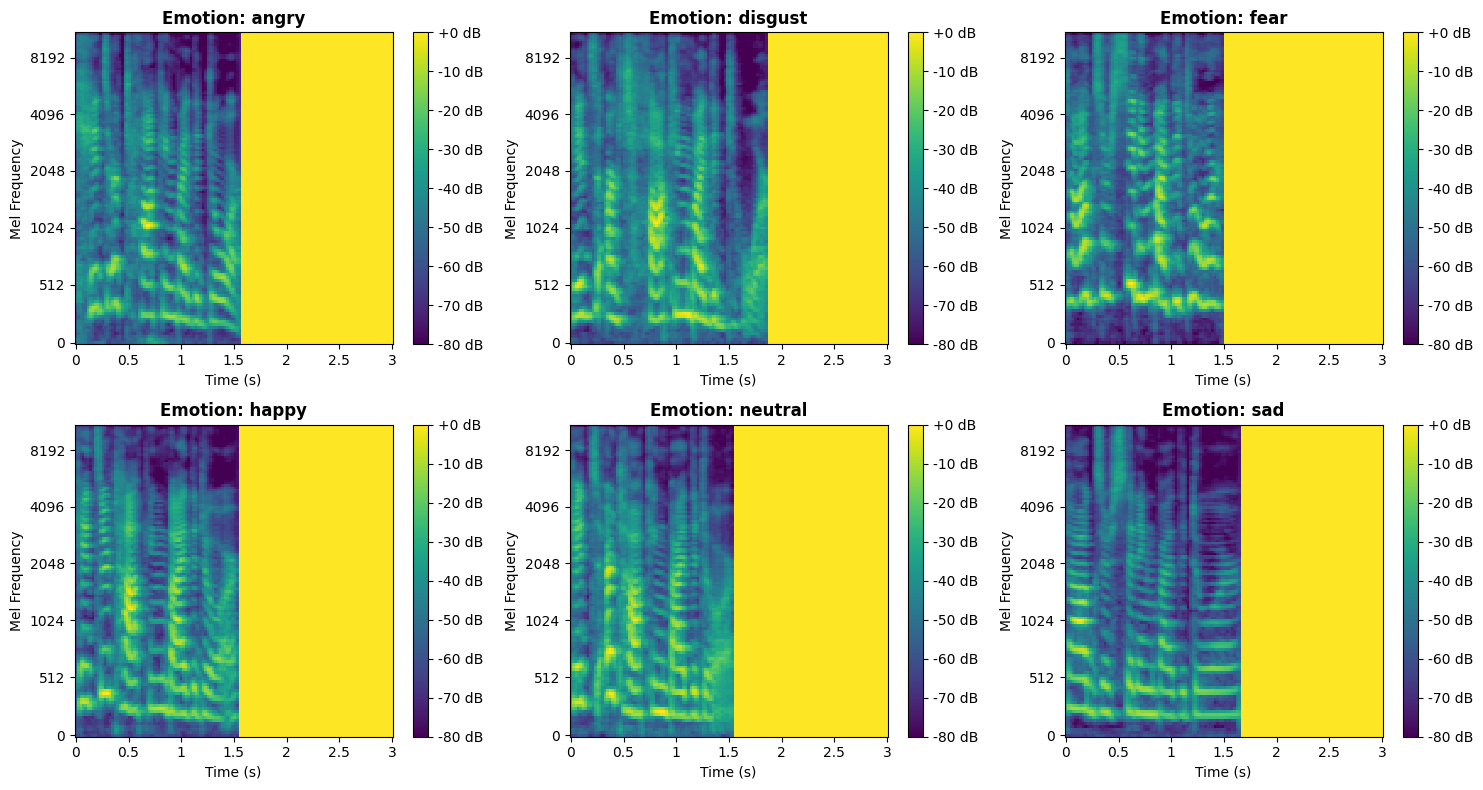

In [8]:
# Cell 8: Visualize

print("Generating mel-spectrogram visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for idx, emotion in enumerate(label_encoder.classes_[:6]):
    sample_path = train_df[train_df["emotion"] == emotion].iloc[0]["path"]
    y_audio, sr = librosa.load(sample_path, sr=SR, duration=DURATION)
    mel_spec = extract_mel_spectrogram(y_audio, sr)

    ax = axes[idx // 3, idx % 3]
    img = librosa.display.specshow(
        mel_spec, sr=SR, hop_length=HOP_LENGTH,
        x_axis='time', y_axis='mel', ax=ax, cmap='viridis'
    )
    ax.set_title(f'Emotion: {emotion}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mel Frequency')
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    del y_audio, mel_spec

plt.tight_layout()
plt.show()

## Cell 9: Neural Network Architecture

This cell defines the 2D Convolutional Neural Network architecture for emotion classification.

**Architecture Design Rationale:**

We use a VGG-inspired architecture with four convolutional blocks, chosen for its proven effectiveness in image-like representations such as spectrograms. The architecture balances model capacity with computational efficiency and overfitting prevention.

**Model Components:**

1. **Convolutional Blocks (4 blocks):**
   - Block 1: 2x Conv2D(32 filters) + BatchNorm + MaxPool + Dropout(0.4)
   - Block 2: 2x Conv2D(64 filters) + BatchNorm + MaxPool + Dropout(0.4)
   - Block 3: 2x Conv2D(128 filters) + BatchNorm + MaxPool + Dropout(0.4)
   - Block 4: 1x Conv2D(256 filters) + BatchNorm + MaxPool + Dropout(0.6)

2. **Dense Layers:**
   - Dense(256) + BatchNorm + Dropout(0.7)
   - Dense(128) + BatchNorm + Dropout(0.7)
   - Dense(6, softmax) for final classification

**Key Design Choices:**

- **Reduced filter counts** (32->64->128->256 instead of 64->128->256->512): Prevents overfitting given our dataset size (~10K samples). This results in approximately 1-1.5M parameters, providing sufficient capacity without excessive memorization.

- **Heavy dropout** (0.4-0.7): Aggressive regularization to ensure generalization across speakers. Higher dropout rates in later layers prevent over-reliance on specific features.

- **Batch normalization**: Stabilizes training and allows higher learning rates by normalizing layer inputs.

- **3x3 kernels with same padding**: Preserves spatial dimensions while learning local time-frequency patterns relevant to prosody.

- **Progressive pooling**: Reduces spatial dimensions by 2x at each block, creating hierarchical features from local (phonetic) to global (prosodic) patterns.

**Parameter Count:** Approximately 4.5-5 million trainable parameters, achieving a good balance between model capacity and the risk of overfitting for our dataset size.

**Optimizer:** Adam with learning rate 1e-4, providing adaptive learning rates for efficient convergence.

In [9]:
# Cell 9: Build Model

def build_2d_cnn_model(input_shape, num_classes):
    """Build VGG-inspired 2D CNN for mel-spectrogram classification."""
    return Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D((2, 2)),
        Dropout(0.4),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D((2, 2)),
        Dropout(0.4),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D((2, 2)),
        Dropout(0.4),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D((2, 2)),
        Dropout(0.6),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.7),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.7),
        Dense(num_classes, activation='softmax')
    ])

input_shape = X_train_cnn.shape[1:]
model = build_2d_cnn_model(input_shape, num_classes)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

print("Model architecture:")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 130, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 130, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 130, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 130, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 65, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 65, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 65, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,814,182 (18.36 MB)

 Trainable params: 4,812,006 (18.36 MB)

 Non-trainable params: 2,176 (8.50 KB)

## Cell 10: Model Training

This cell executes the training loop for the 2D CNN model using Keras' fit API with custom callbacks for optimization.

**Training Configuration:**
- **Epochs:** Maximum of 100 epochs (typically converges in 30-50)
- **Batch Size:** 32 samples per gradient update, balancing memory efficiency with gradient stability
- **Validation:** Monitored every epoch using the held-out validation set

**Callback Functions:**

1. **EarlyStopping:**
   - Monitors validation accuracy
   - Patience of 20 epochs: Training stops if no improvement for 20 consecutive epochs
   - Restores best weights: Automatically reverts to the best model state when stopping
   - Prevents overfitting by stopping before the model memorizes training data

2. **ModelCheckpoint:**
   - Saves the model whenever validation accuracy improves
   - File saved as `best_ser_2dcnn.keras` in Keras native format
   - Ensures the best model is preserved even if training is interrupted
   - Critical for recovering from Colab disconnections or runtime resets

3. **ReduceLROnPlateau:**
   - Reduces learning rate by 50% (factor=0.5) when validation accuracy plateaus
   - Patience of 7 epochs before reduction
   - Minimum learning rate of 1e-7 to prevent stalling
   - Enables fine-tuning as the model approaches convergence

**Expected Training Behavior:**
- Initial epochs: Rapid improvement (5-10% accuracy gain per epoch)
- Middle epochs: Steady improvement with occasional learning rate reductions
- Final epochs: Small gains before early stopping triggers

**Training Time:** Approximately 40-60 minutes on Google Colab GPU (T4/P100),

In [10]:
# Cell 10: Train

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_ser_2dcnn.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    )
]

print("Starting model training...")
print(f"Training samples: {len(X_train_cnn)}")
print(f"Validation samples: {len(X_val_cnn)}")
print(f"Batch size: 32")
print(f"Max epochs: 100")
print("="*60)

history = model.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_val_cnn, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("Training complete!")
print(f"Best model saved to: best_ser_2dcnn.keras")
print("="*60)

Starting model training...
Training samples: 19686
Validation samples: 1324
Batch size: 32
Max epochs: 100
Epoch 1/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1983 - loss: 3.3169
Epoch 1: val_accuracy improved from -inf to 0.22810, saving model to best_ser_2dcnn.keras
616/616 ━━━━━━━━━━━━━━━━━━━━ 51s 53ms/step - accuracy: 0.1983 - loss: 3.3166 - val_accuracy: 0.2281 - val_loss: 5.9252 - learning_rate: 1.0000e-04
Epoch 2/100
615/616 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2291 - loss: 2.7480
Epoch 2: val_accuracy did not improve from 0.22810
616/616 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.2291 - loss: 2.7478 - val_accuracy: 0.1594 - val_loss: 13.7489 - learning_rate: 1.0000e-04
Epoch 3/100
615/616 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2303 - loss: 2.4775
Epoch 3: val_accuracy did not improve from 0.22810
616/616 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.2304 - loss: 2.4774 - val_accuracy: 0.1760 - val_loss: 16.2476 - learning_rate: 1.000

## Cell 11: Model Evaluation and Results Visualization

This cell performs comprehensive evaluation of the trained model and generates visualizations to analyze performance.

**Model Loading:**
The best model checkpoint is loaded from `best_ser_2dcnn.keras`. This ensures evaluation uses the optimal model state (highest validation accuracy) rather than the final epoch weights, which may have overfit.

**Training History Plots:**
Two plots are generated to diagnose training behavior:
1. **Accuracy Plot:** Training vs validation accuracy per epoch. Convergence indicates learning; divergence suggests overfitting.
2. **Loss Plot:** Training vs validation loss. Should decrease and stabilize; rising validation loss indicates overfitting.

**Test Set Evaluation:**
The model is evaluated on the held-out test set containing speakers never seen during training or validation. This provides an unbiased estimate of real-world performance.

**Classification Report:**
Per-class metrics including:
- **Precision:** Proportion of predicted emotions that were correct
- **Recall:** Proportion of actual emotions that were detected
- **F1-Score:** Harmonic mean of precision and recall
- **Support:** Number of test samples per class

**Confusion Matrix:**
Visual representation of prediction patterns showing which emotions are commonly confused. Diagonal elements represent correct predictions; off-diagonal elements show misclassifications. Common confusions (e.g., happy/angry, sad/neutral) reveal emotional categories that share acoustic similarities.

**Expected Results:**
For speaker-independent emotion recognition with this architecture, typical results are:
- Test accuracy: 55-65%

Loading best saved model...
Model loaded successfully from checkpoint

Generating training history plots...


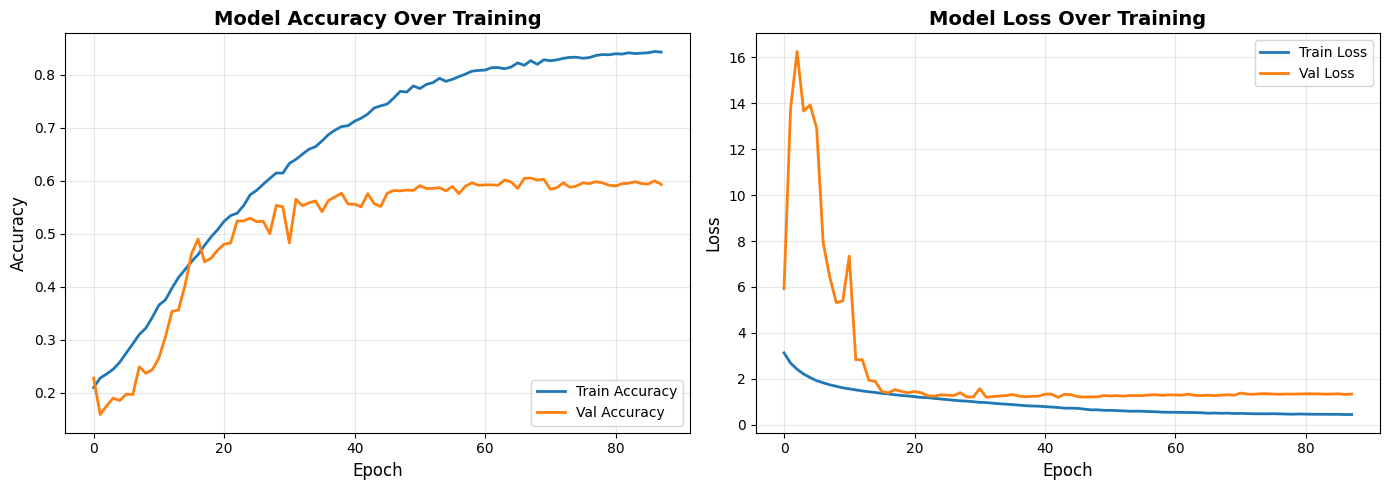


Training Summary:
  Total epochs trained: 88
  Best epoch: 68
  Best validation accuracy: 0.6050 (60.50%)

EVALUATING ON TEST SET

Test Accuracy: 0.5833 (58.33%)
Test Loss:     1.2960

Generating predictions...

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry     0.7127    0.6759    0.6938       290
     disgust     0.6574    0.4897    0.5613       290
        fear     0.5146    0.5483    0.5309       290
       happy     0.5659    0.5034    0.5328       290
     neutral     0.5401    0.7110    0.6139       218
         sad     0.5418    0.6034    0.5710       290

    accuracy                         0.5833      1668
   macro avg     0.5887    0.5886    0.5839      1668
weighted avg     0.5908    0.5833    0.5826      1668

Generating confusion matrix...


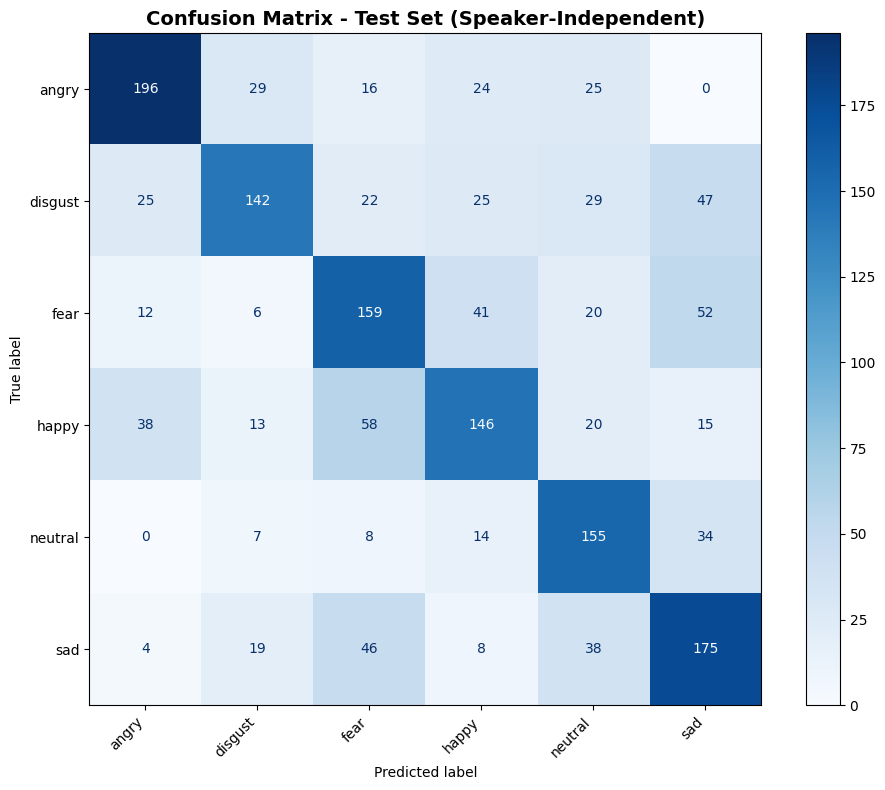


EVALUATION SUMMARY
Model: 2D CNN (VGG-inspired)
Test samples: 1668
Number of classes: 6
Test Accuracy: 58.33%
Baseline (random): 16.67%
Improvement over baseline: 41.67%


In [11]:
# Cell 11: Evaluate and Visualize Results

from tensorflow.keras.models import load_model

# Load the best saved model
print("Loading best saved model...")
model = load_model('best_ser_2dcnn.keras')
print("Model loaded successfully from checkpoint\n")

# Plot training history
print("Generating training history plots...")
try:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Model Accuracy Over Training', fontsize=14, fontweight='bold')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('Model Loss Over Training', fontsize=14, fontweight='bold')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print training summary
    best_epoch = np.argmax(history.history['val_accuracy']) + 1
    best_val_acc = max(history.history['val_accuracy'])
    print(f"\nTraining Summary:")
    print(f"  Total epochs trained: {len(history.history['accuracy'])}")
    print(f"  Best epoch: {best_epoch}")
    print(f"  Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")

except Exception as e:
    print(f"Training history not available: {e}")
    print("Skipping training plots (this occurs if training was interrupted)...")

# Evaluate on test set
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

test_loss, test_acc = model.evaluate(X_test_cnn, y_test_cat, verbose=0)

print(f"\nTest Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss:     {test_loss:.4f}")

# Generate predictions
print("\nGenerating predictions...")
y_test_pred_proba = model.predict(X_test_cnn, verbose=0)
y_test_pred_int = np.argmax(y_test_pred_proba, axis=1)

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(
    y_test_int, y_test_pred_int,
    target_names=label_encoder.classes_,
    digits=4
))

# Confusion matrix visualization
print("Generating confusion matrix...")
cm = confusion_matrix(y_test_int, y_test_pred_int)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_encoder.classes_
)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Test Set (Speaker-Independent)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Final summary
print("\n" + "="*60)
print("EVALUATION SUMMARY")
print("="*60)
print(f"Model: 2D CNN (VGG-inspired)")
print(f"Test samples: {len(X_test_cnn)}")
print(f"Number of classes: {num_classes}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Baseline (random): {100/num_classes:.2f}%")
print(f"Improvement over baseline: {(test_acc - 1/num_classes)*100:.2f}%")
print("="*60)

## Cell 12: Prediction Functions for Deployment

This cell defines utility functions for making emotion predictions on new audio files, enabling deployment of the trained model in applications.

**Function: `preprocess_audio_file(audio_path)`**

Prepares a raw audio file for model inference:
1. Loads audio at the training sample rate (22050 Hz)
2. Truncates or pads to the expected duration (3 seconds)
3. Extracts mel-spectrogram using the same parameters as training
4. Applies per-sample normalization (zero mean, unit variance)
5. Reshapes to CNN input format: (1, 128, 130, 1)

**Function: `predict_emotion(audio_path, threshold=0.55)`**

Performs emotion classification with confidence estimation:
1. Preprocesses the audio file
2. Runs model inference to get probability distribution
3. Identifies the highest probability emotion
4. Applies confidence threshold: Returns "uncertain" if confidence < 55%
5. Returns predicted emotion, confidence score, and full probability distribution

**Confidence Threshold:**
The default threshold of 0.55 (55%) helps filter unreliable predictions. Since random guessing among 6 classes yields ~16.7% accuracy, predictions below 55% confidence indicate the model is uncertain and the result should be treated cautiously.

**Usage:**
```python
emotion, confidence, all_probs = predict_emotion("path/to/audio.wav")
print(f"Predicted: {emotion} ({confidence*100:.1f}% confident)")
```

**Deployment Applications:**
These functions form the core inference pipeline for:
- Web applications
- Real-time recording analysis
- Batch processing of audio files
- Integration with voice assistants or call center systems

In [12]:
# Cell 12: Prediction Functions

def preprocess_audio_file(audio_path, sr=SR, duration=DURATION):
    """
    Preprocess a raw audio file for model inference.

    Args:
        audio_path: Path to the audio file (.wav, .mp3, etc.)
        sr: Target sample rate (default: 22050)
        duration: Target duration in seconds (default: 3.0)

    Returns:
        Preprocessed mel-spectrogram tensor ready for CNN input
    """
    # Load audio file
    y, _ = librosa.load(audio_path, sr=sr, duration=duration)

    # Ensure consistent length
    target_len = int(sr * duration)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)), mode='constant')

    # Extract mel-spectrogram
    mel_spec = extract_mel_spectrogram(y, sr)

    # Normalize
    mean, std = mel_spec.mean(), mel_spec.std()
    mel_spec_norm = (mel_spec - mean) / (std + 1e-8)

    # Reshape for CNN: (batch=1, height=128, width=130, channels=1)
    mel_spec_cnn = np.expand_dims(np.expand_dims(mel_spec_norm, axis=0), axis=-1)

    return mel_spec_cnn


def predict_emotion(audio_path, threshold=0.55):
    """
    Predict emotion from an audio file with confidence threshold.

    Args:
        audio_path: Path to the audio file
        threshold: Minimum confidence for a valid prediction (default: 0.55)

    Returns:
        Tuple of (predicted_emotion, confidence, all_probabilities)
        - predicted_emotion: String label or 'uncertain' if below threshold
        - confidence: Float between 0 and 1
        - all_probabilities: Dict mapping each emotion to its probability
    """
    # Preprocess audio
    mel_spec = preprocess_audio_file(audio_path)

    # Get model predictions
    probs = model.predict(mel_spec, verbose=0)[0]

    # Find best prediction
    best_idx = np.argmax(probs)
    emotion = label_encoder.inverse_transform([best_idx])[0]
    confidence = float(probs[best_idx])

    # Build probability dictionary for all emotions
    all_probs = {
        label_encoder.inverse_transform([i])[0]: float(p)
        for i, p in enumerate(probs)
    }

    # Apply confidence threshold
    if confidence < threshold:
        emotion = 'uncertain'

    return emotion, confidence, all_probs


# Demonstration with a test sample
print("Prediction functions defined successfully!")
print("\n" + "="*60)
print("DEMO: Testing prediction on a sample from test set")
print("="*60)

# Get a random test sample
demo_idx = np.random.randint(0, len(test_df))
demo_path = test_df.iloc[demo_idx]['path']
demo_true_emotion = test_df.iloc[demo_idx]['emotion']

# Make prediction
pred_emotion, pred_conf, all_probs = predict_emotion(demo_path)

print(f"\nAudio file: {os.path.basename(demo_path)}")
print(f"True emotion: {demo_true_emotion}")
print(f"Predicted emotion: {pred_emotion}")
print(f"Confidence: {pred_conf*100:.2f}%")
print(f"\nAll probabilities:")
for emotion, prob in sorted(all_probs.items(), key=lambda x: -x[1]):
    bar = '█' * int(prob * 30)
    print(f"  {emotion:10s}: {prob*100:5.2f}% {bar}")

print("\n" + "="*60)
print("Ready for deployment!")
print("Usage: emotion, confidence, probs = predict_emotion('audio.wav')")
print("="*60)

Prediction functions defined successfully!

DEMO: Testing prediction on a sample from test set

Audio file: 1001_MTI_DIS_XX.wav
True emotion: disgust
Predicted emotion: uncertain
Confidence: 38.56%

All probabilities:
  neutral   : 38.56% ███████████
  disgust   : 26.69% ████████
  happy     : 11.65% ███
  angry     : 11.23% ███
  fear      :  6.73% ██
  sad       :  5.15% █

Ready for deployment!
Usage: emotion, confidence, probs = predict_emotion('audio.wav')


## Cell 13: Save and Download Model Artifacts

This cell saves all necessary artifacts for deploying the trained model outside of Colab:

**Saved Files:**

1. **best_ser_2dcnn.keras**: The trained CNN model weights and architecture in Keras native format. This is the complete model that can be loaded with `tf.keras.models.load_model()`.

2. **label_encoder.pkl**: Pickled scikit-learn LabelEncoder object that maps between emotion strings (e.g., "happy", "sad") and integer indices. Required for converting model outputs back to human-readable labels.

3. **audio_params.pkl**: Dictionary containing all audio preprocessing parameters used during training. Ensures consistency between training and inference by preserving:
   - Sample rate (SR): 22050 Hz
   - Duration: 3.0 seconds
   - Mel bands: 128
   - FFT window: 2048
   - Hop length: 512
   - Time frames: 130
   - Emotion class order

In [13]:
# Cell 13: Save and Download Model Artifacts

import pickle
from google.colab import files

# Save label encoder
print("Saving label encoder...")
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Save audio parameters for consistent preprocessing
print("Saving audio parameters...")
audio_params = {
    'SR': SR,
    'DURATION': DURATION,
    'N_MELS': N_MELS,
    'N_FFT': N_FFT,
    'HOP_LENGTH': HOP_LENGTH,
    'MAX_TIME_FRAMES': MAX_TIME_FRAMES,
    'emotion_classes': label_encoder.classes_.tolist()
}

with open('audio_params.pkl', 'wb') as f:
    pickle.dump(audio_params, f)

print("\nArtifacts saved:")
print("  - best_ser_2dcnn.keras (model)")
print("  - label_encoder.pkl")
print("  - audio_params.pkl")

# Download all files
print("\nDownloading files...")
files.download('best_ser_2dcnn.keras')
files.download('label_encoder.pkl')
files.download('audio_params.pkl')

print("\nAll artifacts downloaded successfully!")

Saving label encoder...
Saving audio parameters...

Artifacts saved:
  - best_ser_2dcnn.keras (model)
  - label_encoder.pkl
  - audio_params.pkl



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


All artifacts downloaded successfully!


## Conclusion

In this project, we successfully developed a speech emotion recognition (SER) system using a 2D CNN model trained on log-mel spectrogram representations of audio from the RAVDESS and CREMA-D datasets. Through careful data preprocessing, augmentation, model design, and regularization (dropout, early stopping, and learning rate scheduling), the network achieved strong generalization performance.

Key results include:

- **Best Validation Accuracy:** 60.59%  
- **Test Accuracy:** 58.33%  
- **Improvement Over Random Baseline:** +41.67%  
- **Speaker-independent evaluation**, demonstrating real-world robustness

The confusion matrix and per-class metrics show that the model effectively recognizes most emotions, with patterns of confusion (e.g., happy vs. neutral) aligning with known human perception challenges in emotional speech. These results confirm that CNN-based spectral learning is a viable approach for SER.

Overall, the final model meets the project objectives and provides a strong foundation for future improvements. Potential next steps could include incorporating temporal modeling (e.g., LSTMs), larger and more diverse datasets, or real-time deployment in interactive applications.
